# Laboratorio 1 - Aprendizaje de Máquina
Sergio Ferreira - Juan David Gutierrez


- [Carga de datos](#carga-de-datos)
- [Limpieza de datos](#limpieza-de-datos)
    - [Transformación de variables categóricas](#2_1)
    - [Valores atípicos](#2_2)
- [Transformación de los datos](#3)
    - [Completitud e Imputación](#3_1)
    - [Multicolinealidad](#multicolinealidad)
    - [Correlación con la variable objetivo](#3_3)
    - [Escalado de los datos](#escalado-de-los-datos)


---
## Librerias utilizadas

In [50]:
import pandas as pd
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

---
## Carga de datos

In [51]:
data_cvd = pd.read_csv('data/Datos Lab 1.csv')

# Trabajamos con una copia de los datos
data = data_cvd.copy()

data.sample(3)

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
762,QaBF6317,2025-06-21,M,66.0,105.196,NaN,26.421,92.347,91/97,275.0,...,High,N,168.959,0.547,91.0,97.0,Hypertension Stage 2,158.0,17.334,INTERMEDIARY
168,GhAr2320,2021-08-04,F,32.0,98.300,1.78,31.000,93.000,127/98,261.0,...,High,Y,178.000,0.522,127.0,98.0,Hypertension Stage 2,189.0,19.770,HIGH
658,yAIB3468,29 Jan 22,F,53.0,70.300,1.67,6.235,88.800,130/97,277.0,...,Low,Y,167.000,0.532,130.0,97.0,Hypertension Stage 1,187.0,17.080,HIGH


---
## Limpieza de datos


### Pacientes duplicados
Inicialmente vamos a verificar si existen pacientes duplicados y de existir guardar únicamente la entrada más reciente.

In [52]:
dup_counts = (data['Patient ID'].value_counts()
                        .loc[lambda s: s > 1]
                        .sort_values(ascending=False))
print("Pacientes duplicados:", len(dup_counts))
dup_counts

Pacientes duplicados: 171


Patient ID
oSqq7069    3
gBFe4249    3
AhYt1346    3
RlsB8509    3
RwGu5647    3
           ..
rKiV2789    2
ejaQ6145    2
ahGL8318    2
MgXe4245    2
pgnn4679    2
Name: count, Length: 171, dtype: int64

Observamos las filas asociadas para uno de los pacientes cuyo ID aparece más de una vez.

In [53]:
data[data['Patient ID']=="oSqq7069"]

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
10,oSqq7069,18 Jun 23,F,38.0,68.516,1.929,39.967,96.957,105/84,241.0,...,Moderate,Y,192.936,0.503,105.0,84.0,Hypertension Stage 1,159.0,18.063,HIGH
430,oSqq7069,18 Jun 23,F,38.0,68.516,1.929,39.967,96.957,105/84,241.0,...,Moderate,Y,192.936,0.503,105.0,84.0,Hypertension Stage 1,159.0,18.063,HIGH
1586,oSqq7069,18 Jun 23,F,38.0,68.516,1.929,39.967,96.957,105/84,241.0,...,Moderate,Y,192.936,0.503,105.0,84.0,Hypertension Stage 1,159.0,33.384,HIGH


Para poder comparar las fechas de servicio en la columna *Date of Service* vamos a estandarizar las fechas, pues están con formatos mezclados, para esto utilizaremos la función `to_datetime` de la librería `pandas`

In [54]:
data['Date of Service'] = pd.to_datetime(data['Date of Service'], format='mixed')
data.sample(5)

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
650,VtSy4472,2021-01-30,F,34.0,NaN,1.976,36.827,109.577,100/84,216.0,...,High,N,197.581,0.555,100.0,84.0,Hypertension Stage 1,131.0,16.685,LOW
1414,kxWi2841,2022-10-12,M,34.0,66.400,1.880,18.800,106.300,104/64,283.0,...,High,N,188.000,0.565,104.0,64.0,Normal,188.0,16.620,INTERMEDIARY
491,KGuE6384,2021-11-20,F,33.0,105.351,1.680,28.038,109.807,146/91,288.0,...,High,Y,167.977,0.654,146.0,91.0,Hypertension Stage 2,210.0,20.668,LOW
1405,vYLW1606,2020-09-23,M,68.0,NaN,1.851,20.474,97.393,160/99,279.0,...,High,Y,185.117,0.526,160.0,99.0,Hypertension Stage 2,NaN,17.675,INTERMEDIARY
580,ZmqX9231,2022-05-19,M,55.0,100.100,1.740,33.100,96.600,115/73,287.0,...,Moderate,N,174.000,0.555,115.0,73.0,Normal,217.0,18.110,HIGH


Cómo se observa ahora todas las fechas mantienen el formato `YYYY-MM-DD`, así que podemos eliminar los registros duplicados de un paciente

In [55]:
data = data.sort_values(['Patient ID', 'Date of Service'], ascending=[True, False])
data = data.drop_duplicates(subset='Patient ID', keep='first')

# Observamos nuevamente el paciente que estaba duplicado.
data[data['Patient ID']=="oSqq7069"]

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
10,oSqq7069,2023-06-18,F,38.0,68.516,1.929,39.967,96.957,105/84,241.0,...,Moderate,Y,192.936,0.503,105.0,84.0,Hypertension Stage 1,159.0,18.063,HIGH


<a id="2_1"></a>
### Codificación de variables categóricas

Ahora nos enfocaremos en convertir los descriptores con variables categóricas a variables numéricas, vital para la predicción basada en regresión, las variables a transformar son:

In [56]:
data.iloc[:, [2, 8, 12, 13, 14, 15, 20]].info()

<class 'pandas.DataFrame'>
Index: 1376 entries, 675 to 799
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Sex                      1376 non-null   str  
 1   Blood Pressure (mmHg)    1376 non-null   str  
 2   Smoking Status           1376 non-null   str  
 3   Diabetes Status          1376 non-null   str  
 4   Physical Activity Level  1376 non-null   str  
 5   Family History of CVD    1376 non-null   str  
 6   Blood Pressure Category  1376 non-null   str  
dtypes: str(7)
memory usage: 86.0 KB


En este punto transformaremos las variables *Sex*, *Smoking Status*, *Diabetes Status* y *Family History of CVD* que pueden transformarse a variables binarias, por convención tomaremos los valores `Y` y `F` (en el caso de *Sex*) como 1 y los valores `N` y `M` como 0. Este es nuestro primer paso para la construcción de nuestro pipeline, que nos ayudará a transformar datos de prueba consistentemente con la transformación de los datos de entrenamiento.

In [57]:
numeric_features = [
    "Age", "Weight (kg)", "Height (m)", "Height (cm)", "BMI", "Abdominal Circumference (cm)", 
    "Total Cholesterol (mg/dL)", "HDL (mg/dL)", "Fasting Blood Sugar (mg/dL)", 
    "Waist-to-Height Ratio", "Systolic BP", "Diastolic BP", "Estimated LDL (mg/dL)"
]

ordinal_features = [
    "Physical Activity Level", "Blood Pressure Category"
]

binary_features = [
    "Sex", "Smoking Status", "Diabetes Status", "Family History of CVD"
]

In [58]:
binary_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy=lambda x: random.randint(0, 1)))
])

Continuamos transformando las variables ordinales: 
* *Physical Activity Level*
* *Blood Pressure Category*
* *CVD Risk Level* 

Usaremos una codificación ordinal.

In [59]:
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories = [
        ['Low', 'Moderate', 'High'],  # Physical Activity Level
        ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2']  # Blood Pressure Category
    ]))
])

### Eliminación de variables redundantes

Finalmente, debemos codificar la variable *Blood Pressure* la cual está reportada con dos valores en columnas adicionales que separan estos valores en *Systolic BP* y *Diastolic BP*, por lo que esta columna no presenta información nueva y puede ser eliminada. 

Adicionalmente, existen otras columnas que pueden ser eliminadas ya que no tienen implicaciones con la variable a predecir, como *Date of Service* o *Patient ID* que son arbitrarias, o que no tienen sentido conocerla antes de realizar la predicción pues son dependientes de la variable a predecir, como *CVD Risk Level*. Esta modificación se añade al pipeline.

In [60]:
col_drop = ['Blood Pressure (mmHg)', 'Patient ID', 'Date of Service', 'CVD Risk Level']
def drop_columns(df):
    return df.drop(columns=col_drop, errors='ignore')

dropper = FunctionTransformer(drop_columns)

Cómo podemos observar, tenemos todas nuestras variables como datos numéricos, necesario para el modelo de regresión lineal. A partir de ahora podemos analizar los datos de nuestras columnas y aplicar transformaciones numéricas para favorecer los resultados del modelo.

<a id="2_2"></a>
### Valores atípicos

Para el buen comportamiento del modelo de regresión es importante eliminar valores atípicos pues el error cuadrático medio usado para optimizar el modelo puede ser sensible a dichos valores. Para observar los valores atípicos seguiremos el criterio de estar 1.5 veces el tamaño del rango intercuartílico alejado de un cuartil extremo.

In [61]:
resultados = []

for columna in numeric_features + ['CVD Risk Score']:
    datos = data[columna].dropna()

    q1 = datos.quantile(0.25)
    q3 = datos.quantile(0.75)
    iqr = q3 - q1

    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    n_outliers = ((datos < limite_inferior) | (datos > limite_superior)).sum()

    resultados.append({
        'variable': columna,
        'outliers': n_outliers
    })

outliers_df = pd.DataFrame(resultados)
outliers_df.sort_values(by='outliers', ascending=False)

,variable,outliers
13,CVD Risk Score,50
11,Diastolic BP,16
8,Fasting Blood Sugar (mg/dL),13
9,Waist-to-Height Ratio,13
0,Age,10
10,Systolic BP,9
4,BMI,7
12,Estimated LDL (mg/dL),7
2,Height (m),4
3,Height (cm),4


Inicialmente, eliminaremos los outliers existentes en *CVD Risk Score* puesto que al ser la variable a predecir, estos valores pueden sesgar altamente el modelo.

In [62]:
q1 = data['CVD Risk Score'].quantile(0.25)
q3 = data['CVD Risk Score'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

data = data[(data['CVD Risk Score'] > limite_inferior) & (data['CVD Risk Score'] < limite_superior)]


Para las demás columnas observaremos diagramas de puntos para observar la dispersión y valores atípicos.

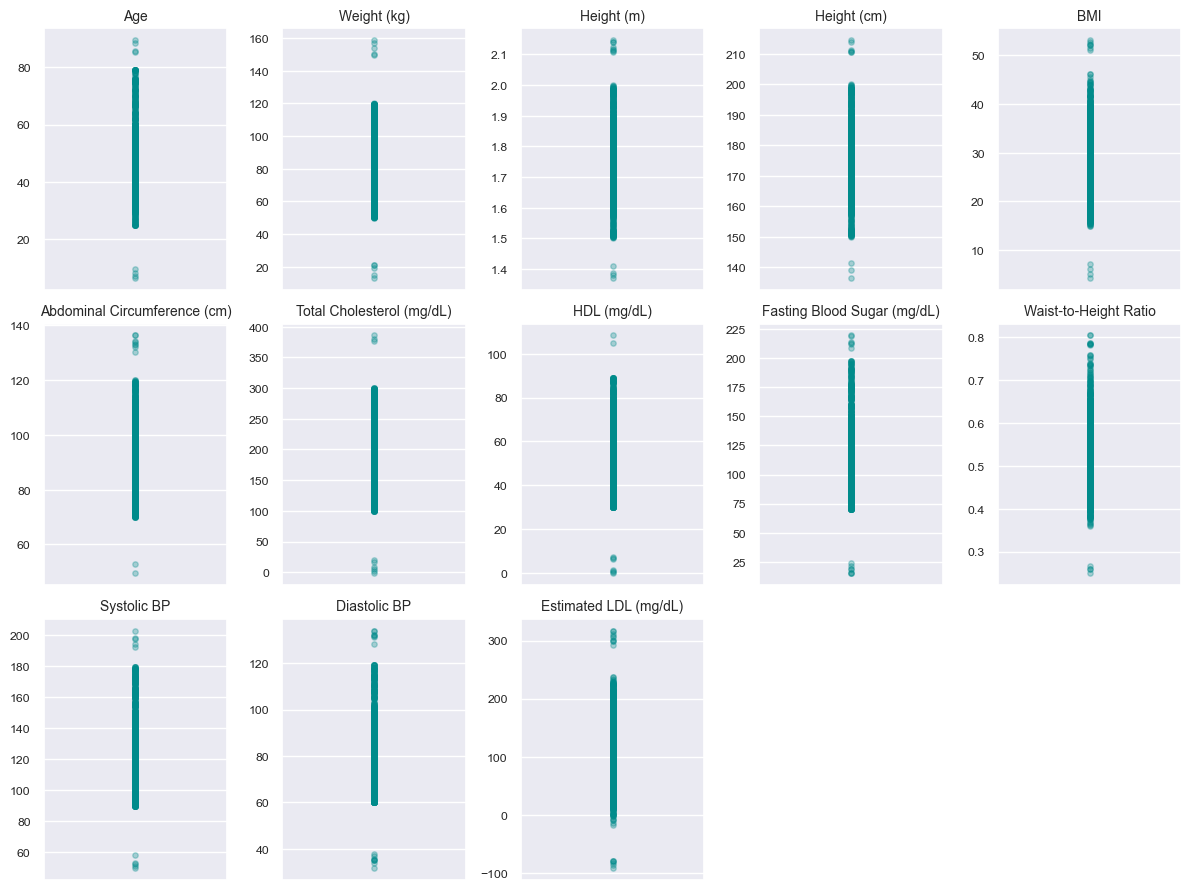

In [63]:
fig, axes = plt.subplots(3, 5, figsize=(12, 9))
axes = axes.flatten()

for i, columna in enumerate(numeric_features):
    datos = data[columna].dropna()

    x = np.zeros_like(datos)
    
    axes[i].scatter(x, datos, alpha=0.3, s=15, color='darkcyan')
    
    axes[i].set_title(columna, fontsize=10)
    axes[i].set_xticks([])
    axes[i].set_xlim(-0.2, 0.2)
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Según los resultados de las gráficas se observan grupos de valores atípicos lejanos de la distribución de los datos, estos valores inviables tienen efectos negativos en un modelo de regresión. Por ejemplo podemos ver que los pesos menores a 30 kg son imposibles para personas adultas de más de 170 cm de estatura, pesos de más de 140kg imposibles para BMI menores a 40, alturas en centimetros que no corresponden a la medición en metros o edades menores a 10 años imposibles para personas de más de 60 kg de peso.

In [64]:
data[data['Weight (kg)'] < 30]

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
1317,ELJn5714,2025-08-04,M,38.0,21.038,1.820,22.600,NaN,113/94,165.0,...,Moderate,Y,182.000,0.541,113.0,94.0,Hypertension Stage 2,79.0,13.470,INTERMEDIARY
291,UQyn8657,2024-08-30,F,37.0,15.036,1.870,25.900,87.600,113/75,252.0,...,High,Y,187.000,0.468,113.0,75.0,Normal,143.0,17.870,HIGH
1041,gdBF9655,2025-03-28,F,68.0,19.578,1.995,29.507,103.497,128/88,134.0,...,Low,N,199.548,0.519,128.0,88.0,Hypertension Stage 1,59.0,14.981,HIGH
1579,raYH9048,2020-07-30,M,40.0,21.316,1.900,24.300,NaN,90/72,216.0,...,High,N,190.000,0.380,90.0,72.0,Normal,125.0,13.680,LOW
1233,uOzX6728,2025-03-24,F,56.0,13.261,1.730,33.400,93.800,145/79,208.0,...,Moderate,N,173.000,0.542,145.0,79.0,Hypertension Stage 2,117.0,18.090,INTERMEDIARY


In [65]:
data[data['Weight (kg)'] > 140]


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
1257,HfIi7486,2022-03-30,F,41.0,158.523,1.700,22.500,75.200,139/60,190.0,...,Low,Y,170.000,0.442,139.0,60.0,Hypertension Stage 1,127.0,17.250,HIGH
223,IaFm9277,2024-10-17,F,60.0,153.556,1.620,NaN,87.200,141/70,174.0,...,Low,N,162.000,0.538,141.0,70.0,Hypertension Stage 2,73.0,17.890,HIGH
1366,KgNL3824,2025-01-12,F,32.0,157.164,1.898,36.837,72.410,125/111,233.0,...,High,Y,189.815,0.381,125.0,NaN,Hypertension Stage 2,151.0,18.277,INTERMEDIARY
586,KjcW1284,2025-11-24,F,35.0,149.335,1.780,NaN,119.672,113/65,173.0,...,High,Y,177.996,0.672,113.0,65.0,Normal,83.0,18.323,HIGH
646,sIAo1776,2025-07-08,F,45.0,149.877,1.616,39.633,109.352,175/98,256.0,...,High,Y,161.584,0.677,175.0,98.0,Hypertension Stage 2,151.0,23.797,LOW


In [66]:
data[data['Age'] < 10]


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
45,DhUJ7239,2020-01-24,M,6.420,69.769,1.696,22.060,74.184,120/76,197.0,...,Low,N,169.560,0.438,120.0,76.0,Elevated,NaN,14.352,INTERMEDIARY
331,WdVf6550,2021-05-11,M,9.376,87.055,1.527,23.245,96.493,103/72,132.0,...,Low,N,152.679,0.632,103.0,72.0,Normal,22.0,12.439,INTERMEDIARY
1553,qXdE2915,2021-08-25,M,7.025,98.700,1.630,37.100,89.700,139/93,158.0,...,Moderate,Y,163.000,0.550,139.0,93.0,Hypertension Stage 1,64.0,19.530,HIGH
1172,rVeE6392,2022-08-06,F,8.038,112.520,1.520,21.988,106.120,117/96,228.0,...,Low,Y,152.020,0.698,117.0,96.0,Hypertension Stage 2,158.0,16.808,LOW


In [67]:
data[data['Height (cm)'] > 200]

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
130,BQvQ6431,2020-09-11,M,33.0,118.300,1.690,41.400,72.10,116/93,171.0,...,Moderate,N,210.554,0.427,116.0,93.0,Hypertension Stage 2,97.0,17.500,LOW
1604,CCbF3794,2024-12-13,F,58.0,69.000,1.870,19.700,77.50,107/88,184.0,...,Low,Y,210.981,0.414,107.0,88.0,Hypertension Stage 1,109.0,14.970,HIGH
1084,GDej6322,2022-09-26,M,55.0,88.834,1.665,27.856,91.37,120/75,106.0,...,Low,N,210.624,NaN,120.0,75.0,Elevated,39.0,13.691,INTERMEDIARY
608,faat5690,2022-12-14,F,46.0,88.100,1.630,33.200,98.70,95/81,166.0,...,Low,Y,213.920,0.606,95.0,81.0,Hypertension Stage 1,58.0,16.710,HIGH
433,lBNs4776,2024-12-26,F,57.0,100.800,1.840,29.800,88.40,110/78,102.0,...,High,N,214.394,0.480,110.0,78.0,Normal,39.0,15.500,HIGH
1277,qcdy4813,2023-11-12,M,37.0,78.100,1.850,22.800,74.20,100/76,118.0,...,Moderate,N,211.127,0.401,100.0,76.0,Normal,18.0,13.920,LOW


Por esta razón establecemos rangos razonables para los datos reemplazando los valores atípicos por fuera de estos rangos por `NaN` para aplicar estrategias de imputación posteriormente.

In [68]:
rangos = {
    'Diastolic BP': (40, 125),
    'Systolic BP': (80, 190),
    'Fasting Blood Sugar (mg/dL)': (60, 200),
    'Total Cholesterol (mg/dL)': (80, 320),
    'HDL (mg/dL)': (20, 100),
    'Estimated LDL (mg/dL)': (0, 250),
    'BMI': (15, 50),
    'Weight (kg)': (30, 140),
    'Height (m)': (1.45, 2),
    'Height (cm)': (145, 200),
    'Abdominal Circumference (cm)': (60, 130),
    'Waist-to-Height Ratio': (0.35, 0.8),
    'Age': (18, 100)
}
def limpiar_rangos(df):
    for col, (min_val, max_val) in rangos.items():
        if col in df.columns:
            df.loc[
                (df[col] <= min_val) | (df[col] >= max_val),
                col
            ] = np.nan
    return df
rangos_validos = FunctionTransformer(limpiar_rangos)

Finalmente añadimos este preprocesamiento al pipeline y lo aplicamos a las variables numéricas para analizarlo de mejor manera antes de la transformación de dichas variables.

In [69]:
numeric_transformer = Pipeline(steps=[
    ('rangos', rangos_validos)
])

In [70]:
def strip_feature_names(feature_names):
    stripped_names = []
    for name in feature_names:
        stripped_names.append(name.replace('binary__', '').replace('ordinal__', '').replace('remainder__', '')
                              .replace('simple_', '').replace('correlated_', '').replace('_M','').replace('_Y',''))
    return stripped_names

---
<a id="3"></a>
## Transformación de los datos

<a id="3_1"></a>
### Completitud e Imputación
Ahora debe observarse el nivel de completitud de las columnas restantes y en base a esto decidir la estrategia de imputación sobre los datos faltantes. Anteriormente garantizamos que el pipeline se encargara de imputar valores faltantes en las variables categóricas, así que para esta sección solo trabajaremos con variables numéricas.

Inicialmente vamos a eliminar las entradas que tengan datos faltantes en *CVD Risk Score* la cual es nuestra variable a predecir.

In [71]:
print("CVD Risk Score faltantes: ", data['CVD Risk Score'].isnull().sum())
data = data.dropna(subset=['CVD Risk Score'])

CVD Risk Score faltantes:  0


In [72]:
clean_numeric_data = numeric_transformer.fit_transform(data)
clean_numeric_data = pd.DataFrame(clean_numeric_data, columns=numeric_features)
clean_numeric_data.describe()

,Age,Weight (kg),Height (m),Height (cm),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL)
count,1236.000000,1227.000000,1241.000000,1233.000000,1243.000000,1243.000000,1234.000000,1224.000000,1240.000000,1230.000000,1235.000000,1228.000000,1227.000000
mean,47.262816,86.198337,1.755085,175.518969,28.557304,91.758523,198.984603,56.253268,117.066935,0.525837,125.824291,82.981270,112.840261
std,12.650537,20.980157,0.113150,11.309207,7.056570,12.839031,57.519408,16.136009,30.459084,0.083041,22.105700,14.819714,57.653778
min,25.000000,50.100000,1.502000,150.000000,15.100000,70.000000,100.000000,30.000000,70.000000,0.360000,90.000000,60.000000,1.000000
25%,37.000000,67.350000,1.668000,166.984000,22.680500,80.544500,151.000000,42.000000,92.000000,0.458250,108.000000,71.000000,63.000000
50%,47.000000,87.400000,1.760000,176.000000,28.300000,91.500000,197.000000,56.000000,115.000000,0.522000,125.000000,82.000000,111.000000
75%,56.000000,105.050000,1.846000,184.449000,34.152000,102.286000,250.000000,70.000000,138.000000,0.583750,141.000000,94.000000,159.000000
max,89.420000,120.000000,1.998000,199.960000,46.200000,119.996000,300.000000,89.000000,198.000000,0.787000,179.000000,119.000000,237.000000


In [73]:
((clean_numeric_data.isnull().sum()/clean_numeric_data.shape[0])).sort_values(ascending=False)

HDL (mg/dL)                     0.057011
Estimated LDL (mg/dL)           0.054700
Weight (kg)                     0.054700
Diastolic BP                    0.053929
Waist-to-Height Ratio           0.052388
Height (cm)                     0.050077
Total Cholesterol (mg/dL)       0.049307
Systolic BP                     0.048536
Age                             0.047766
Fasting Blood Sugar (mg/dL)     0.044684
Height (m)                      0.043914
BMI                             0.042373
Abdominal Circumference (cm)    0.042373
dtype: float64

Cómo se puede observar todas las variables tienen un nivel de completitud de al menos 94%, por lo que no es conveniente eliminar descriptores y se prefiere aplicar estrategias de imputación.
Para cada una de las variables faltantes se buscan variables correlacionadas que puedan ayudar a predecir los valores faltantes, para esto se realiza una matriz de correlación.

<Axes: >

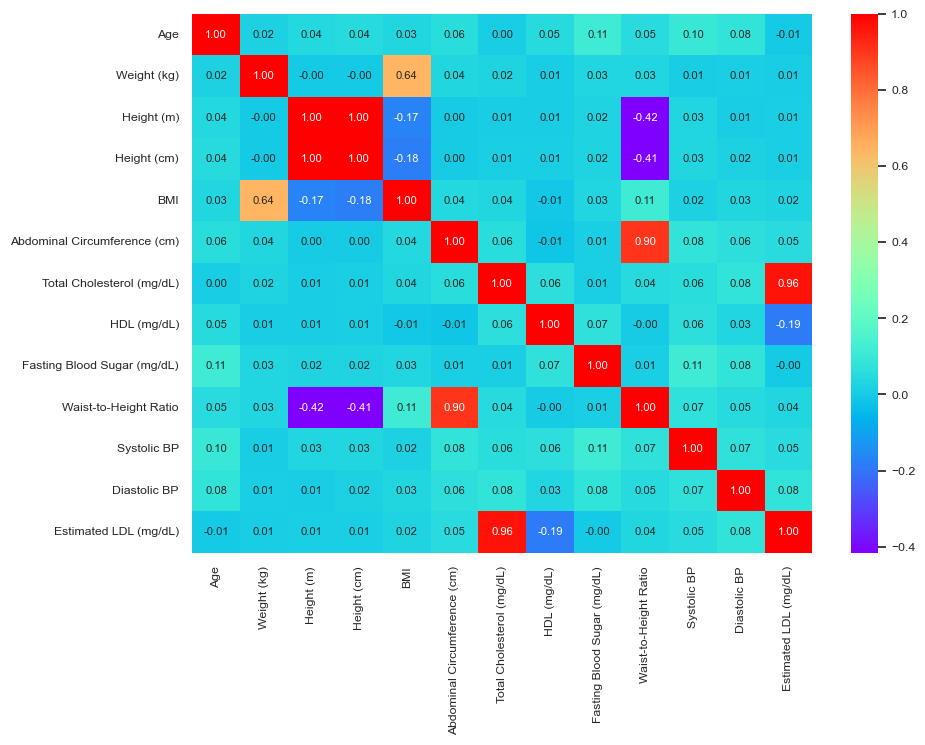

In [74]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_theme(font_scale=0.8)
sns.heatmap(clean_numeric_data.corr(), ax=ax, cmap='rainbow', annot=True, fmt='.2f', annot_kws={"size": 8})

Con respecto a las variables con valores faltantes se pueden establecer las siguientes relaciones de colinealidad:
* *Waist-to-Height Ratio* <--> *Abdominal Circumference*
* *Total Cholesterol* <--> *Estimated LDL*
* *Height (cm)* <--> *Height (m)*

Las demás variables deben ser imputadas independientemente, para esto observaremos la distribución de cada una de ellas.

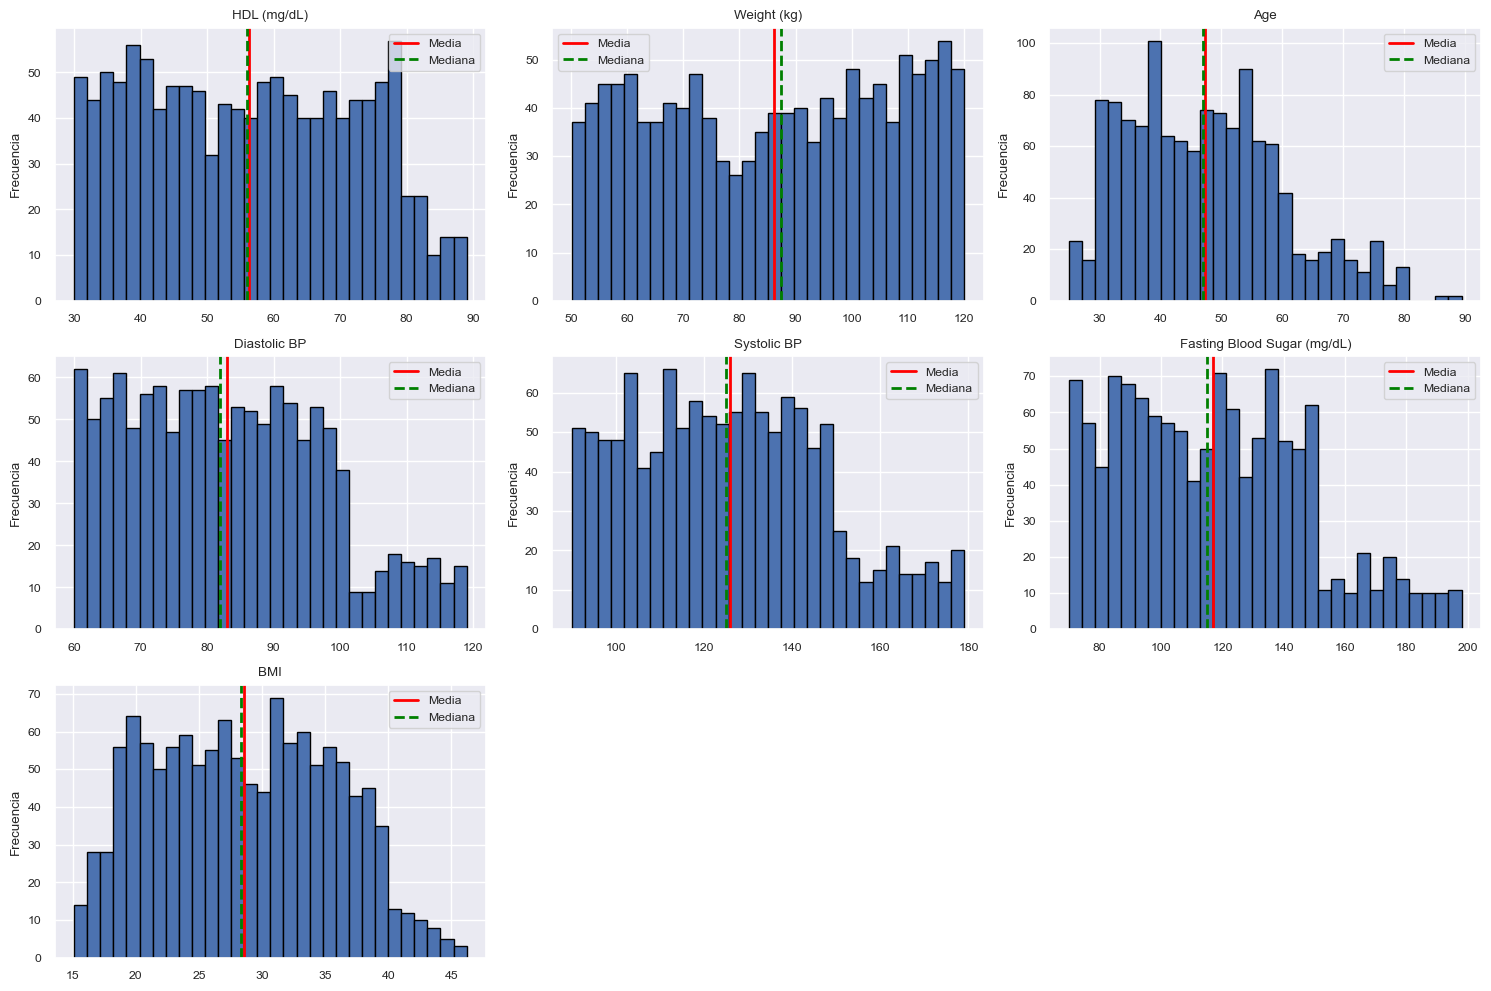

In [75]:
columnas = ['HDL (mg/dL)', 'Weight (kg)', 'Age', 'Diastolic BP', 'Systolic BP', 'Fasting Blood Sugar (mg/dL)', 'BMI']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, columna in enumerate(columnas):
    datos = clean_numeric_data[columna].dropna()
    axes[i].hist(
        datos,
        bins=30,
        edgecolor='black'
    )
    media = datos.mean()
    mediana = datos.median()
    axes[i].axvline(
        media,
        linestyle='-',
        linewidth=2,
        label='Media',
        color='red'
    )
    axes[i].axvline(
        mediana,
        linestyle='--',
        linewidth=2,
        label='Mediana',
        color='green'
    )
    axes[i].set_title(columna)
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend()

for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Dado que en todas las distribuciones se observa una tendencia hacia la media y mediana y dado que estas dos medidas se encuentran muy cercanas entre sí entre todas las distribuciones, se decidió imputar por la mediana a las variables enteras (*Age*, *Diastolic BP*, *Systolic BP*, *HDL* y *Fasting Blood Sugar*) y por la media a las variables flotantes (*Weight* y *BMI*).

In [76]:
median_columns = ['Age', 'Diastolic BP', 'Systolic BP', 'Fasting Blood Sugar (mg/dL)', 'HDL (mg/dL)']
mean_columns = ['Weight (kg)', 'BMI']

def median_transformer_func(X):
    for col in median_columns:
        X[col] = X[col].fillna(clean_numeric_data[col].median())
    return X

def mean_transformer_func(X):
    for col in mean_columns:
        X[col] = X[col].fillna(clean_numeric_data[col].mean())
    return X

median_transformer = FunctionTransformer(median_transformer_func)
mean_transformer = FunctionTransformer(mean_transformer_func)
simple_imputer_transformer = ColumnTransformer(transformers=[
    ('median', median_transformer, median_columns),
    ('mean', mean_transformer, mean_columns)
])

Después de la imputación simple de estas variables independientes podemos imputar por regresión a las variables correlacionadas mencionadas anteriormente.

In [77]:
# Waist to height ratio
temp_abdominal = clean_numeric_data['Abdominal Circumference (cm)'].fillna(clean_numeric_data['Abdominal Circumference (cm)'].mean())
k_waist_to_height_ratio = (clean_numeric_data['Waist-to-Height Ratio'] / temp_abdominal).dropna().median()

# Abdominal circumference
k_abdominal_circumference = (clean_numeric_data['Abdominal Circumference (cm)'] / clean_numeric_data['Waist-to-Height Ratio']).dropna().median()

# Total cholesterol
temp_ldl = clean_numeric_data['Estimated LDL (mg/dL)'].fillna(clean_numeric_data['Estimated LDL (mg/dL)'].mean())
k_total_cholesterol = (clean_numeric_data['Total Cholesterol (mg/dL)'] / temp_ldl).dropna().median()

# Estimated LDL
k_estimated_ldl = (clean_numeric_data['Estimated LDL (mg/dL)'] / clean_numeric_data['Total Cholesterol (mg/dL)']).dropna().median()

# Height (cm)
temp_height_m = clean_numeric_data['Height (m)'].fillna(clean_numeric_data['Height (m)'].mean())

def correlated_imputer(df):
    df['Waist-to-Height Ratio'] = df['Waist-to-Height Ratio'].fillna(k_waist_to_height_ratio * temp_abdominal)
    df['Abdominal Circumference (cm)'] = df['Abdominal Circumference (cm)'].fillna(k_abdominal_circumference * df['Waist-to-Height Ratio'])
    df['Total Cholesterol (mg/dL)'] = df['Total Cholesterol (mg/dL)'].fillna(k_total_cholesterol * temp_ldl)
    df['Estimated LDL (mg/dL)'] = df['Estimated LDL (mg/dL)'].fillna(k_estimated_ldl * df['Total Cholesterol (mg/dL)'])
    df['Height (cm)'] = df['Height (cm)'].fillna(temp_height_m * 100)
    df['Height (m)'] = df['Height (m)'].fillna(df['Height (cm)'] / 100)
    return df

corr_imputer = FunctionTransformer(correlated_imputer)

In [78]:
corr_features = ['Waist-to-Height Ratio', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'Estimated LDL (mg/dL)', 'Height (cm)', 'Height (m)']
imputer_transformer = ColumnTransformer(transformers=[
    ('simple', simple_imputer_transformer, median_columns + mean_columns),
    ('correlated', corr_imputer, corr_features)
])
numeric_transformer.steps.append(('imputer', imputer_transformer))

Con esto completamos el proceso de imputación y observamos que no existen más valores faltantes.

In [79]:
clean_numeric_data = numeric_transformer.fit_transform(data)
numerical_f_names = median_columns + mean_columns + corr_features
clean_numeric_data = pd.DataFrame(clean_numeric_data, columns=numerical_f_names)
((clean_numeric_data.isnull().sum()/clean_numeric_data.shape[0])).sort_values(ascending=False)

Age                             0.0
Diastolic BP                    0.0
Systolic BP                     0.0
Fasting Blood Sugar (mg/dL)     0.0
HDL (mg/dL)                     0.0
Weight (kg)                     0.0
BMI                             0.0
Waist-to-Height Ratio           0.0
Abdominal Circumference (cm)    0.0
Total Cholesterol (mg/dL)       0.0
Estimated LDL (mg/dL)           0.0
Height (cm)                     0.0
Height (m)                      0.0
dtype: float64

### Multicolinealidad

Después del proceso de imputación graficaremos de nuevo la matriz de correlación de los datos, en esta matriz será importante observar las columnas que brinden información redundante o no correlacionada con la columna objetivo, *CVD Risk Score*.

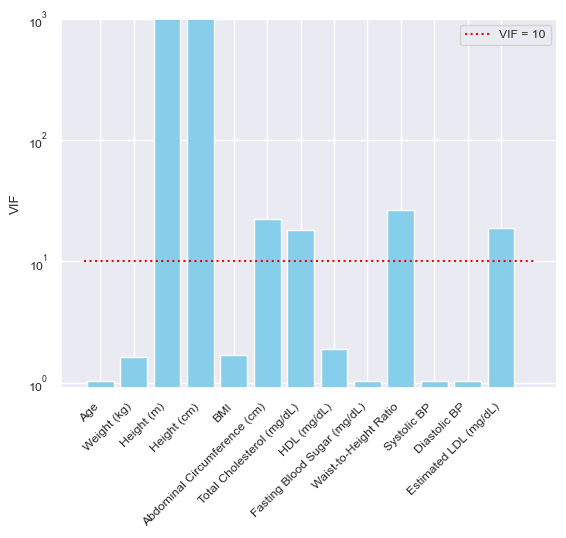

In [80]:
# VIF score
def plot_vif(df, y_max = 12, scale = None):
    X = add_constant(df)
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.iloc[1:]
    plt.bar(vif['Variable'], vif['VIF'], color='skyblue')
    plt.hlines(10, -0.5, len(vif), colors='red', linestyles='dotted', label='VIF = 10')
    if scale == 'log': 
        plt.yscale('log', base = 10)
        plt.ylim(0.9, y_max)
    else:
        plt.ylim(0, y_max)
    plt.ylabel('VIF')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.show()
plot_vif(clean_numeric_data[numeric_features], y_max=1000, scale='log')

A partir de los datos observados podemos afirmar que existen variables con alta multicolinealidad por lo que pueden estar brindando información redundante que puede llegar a confundir al modelo. Por lo tanto se deciden eliminar las variables *Height (cm)*, *Waist-to-Height Ratio* y *Estimated LDL*. 

Además se puede observar una correlación moderada de *Blood Pressure Category* con *Systolic BP* y *Diastolic BP*, sin embargo decidimos eliminar la columna *Blood Pressure Category* puesto que depende directamente de las otras dos columnas y que el no tener un nivel alto de colinealidad se explica por la separación de la variable en rangos.

Graficamos de nuevo el índice VIF para verificar que la multicolinealidad ha desaparecido.

In [81]:
columns_vif=['Height (cm)', 'Waist-to-Height Ratio', 'Estimated LDL (mg/dL)', 'Blood Pressure Category']
def drop_high_vif(df):
    f_names = median_columns + mean_columns + corr_features
    df = pd.DataFrame(df, columns=f_names)
    return df.drop(columns=columns_vif, errors='ignore')
dropper_vif = FunctionTransformer(drop_high_vif)
numeric_transformer.steps.append(('dropper_vif', dropper_vif))

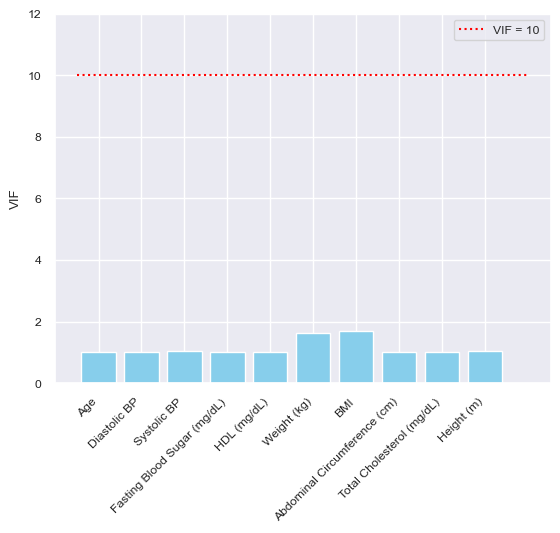

In [82]:
clean_numeric_data = numeric_transformer.fit_transform(data)
numerical_f_names = [col for col in numerical_f_names if col not in columns_vif]
plot_vif(clean_numeric_data, y_max=12, scale=None)

### Escalado de los datos

Seleccionamos las columnas que tenga sentido escalar. Para esto probamos la normalidad de las variables usando la prueba de Kolmogorov-Smirnov con un p-valor de aceptación de 0.05, para verificar cuáles deben normalizarse y cuales deben escalarse.

In [83]:
for col in numerical_f_names:
    ks_statistic, p_value = kstest(clean_numeric_data[col], 'norm', args=(clean_numeric_data[col].mean(), clean_numeric_data[col].std()))
    print(f"Variable: {col}: KS = {ks_statistic:.4f}, p-value = {p_value:.4f}")

Variable: Age: KS = 0.0566, p-value = 0.0005
Variable: Diastolic BP: KS = 0.0665, p-value = 0.0000
Variable: Systolic BP: KS = 0.0489, p-value = 0.0039
Variable: Fasting Blood Sugar (mg/dL): KS = 0.0616, p-value = 0.0001
Variable: HDL (mg/dL): KS = 0.0679, p-value = 0.0000
Variable: Weight (kg): KS = 0.0633, p-value = 0.0001
Variable: BMI: KS = 0.0482, p-value = 0.0047
Variable: Abdominal Circumference (cm): KS = 0.0629, p-value = 0.0001
Variable: Total Cholesterol (mg/dL): KS = 0.0593, p-value = 0.0002
Variable: Height (m): KS = 0.0547, p-value = 0.0008


Para ninguna variable se puede probar normalidad, pues los p-valores de las pruebas estuvieron muy por debajo del umbral, de esta manera se prefiere escalar los datos. Para esto se usara la herramienta `MinMaxScaler` de la librería `Scikit-Learn`.

In [84]:
numeric_transformer.steps.append(('scaler', MinMaxScaler()))
set_config(display='diagram')
numeric_transformer

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('rangos', ...), ('imputer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function lim...00268FD889DD0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments to pass

In [85]:
clean_numeric_data = numeric_transformer.fit_transform(data)
clean_numeric_data = pd.DataFrame(clean_numeric_data, columns=numerical_f_names)
clean_numeric_data.sample(5)

,Age,Diastolic BP,Systolic BP,Fasting Blood Sugar (mg/dL),HDL (mg/dL),Weight (kg),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),Height (m)
243,0.341509,0.016949,0.539326,0.226562,0.508475,0.888412,0.778135,0.152661,0.695941,0.380304
667,0.310463,0.101695,0.662921,0.218750,0.491525,0.248927,0.163987,0.419392,0.383993,0.660528
847,0.170754,0.932203,0.483146,0.195312,0.796610,0.904120,0.249228,0.782312,0.580599,0.018014
44,0.543310,0.372881,0.382022,0.601562,0.508475,0.587983,0.553055,0.117653,0.601570,0.360288
800,0.822726,0.525424,0.404494,0.296875,0.881356,0.160887,0.391511,0.805184,0.533414,0.938751


Finalmente, construimos el pipeline general para los datos.

In [86]:
preprocessing_transformer = ColumnTransformer(transformers=[
    ('binary', binary_transformer, binary_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('numeric', numeric_transformer, numeric_features),
    ('cvd_risk_score', 'passthrough', ['CVD Risk Score'])
])
pipeline_regresion = Pipeline(steps=[
    ('dropper', dropper),
    ('preprocesamiento', preprocessing_transformer)
])
set_config(display="diagram")
pipeline_regresion

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('dropper', ...), ('preprocesamiento', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function dro...00268FD888510>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments to

<a id="3_3"></a>
### Correlación con la variable objetivo


In [87]:
clean_data = pipeline_regresion.fit_transform(data)
f_names = binary_features + ordinal_features + numerical_f_names + ['CVD Risk Score']
clean_data = pd.DataFrame(clean_data, columns=f_names)
corr = clean_data.corr()['CVD Risk Score'].drop('CVD Risk Score').sort_values(ascending=False)
print(corr)

Total Cholesterol (mg/dL)       0.494634
BMI                             0.489323
Diabetes Status                 0.452277
Systolic BP                     0.322879
Weight (kg)                     0.274287
Blood Pressure Category         0.271471
Abdominal Circumference (cm)    0.112601
Fasting Blood Sugar (mg/dL)     0.074194
Age                             0.051502
HDL (mg/dL)                     0.034749
Family History of CVD           0.022383
Diastolic BP                    0.015024
Sex                             0.013058
Smoking Status                  0.012915
Physical Activity Level         0.005436
Height (m)                     -0.099671
Name: CVD Risk Score, dtype: float64


En cuanto a la correlación de las variables con la columna a predecir, se observa que las variables *Sex*, *Smoking Status*, *Physical Activity Level* y *Diastolic BP* tienen una baja correlación con *CVD Risk Score*, sin embargo son variables que a priori tienen un efecto sobre el riesgo de enfermedades cardiovasculares; por lo tanto se tomó la decisión de construir dos modelos, el primero con todas las variables que se tienen hasta el momento y el segundo eliminando estas variables que no muestran correlación con la variable a predecir.

In [88]:
# Datos para la construccion del primer modelo
data_model1 = clean_data.copy()

# Datos para la construccion del segundo modelo
data_model2 = clean_data.copy()
data_model2 = data_model2.drop(columns=['Sex', 'Smoking Status', 'Physical Activity Level', 'Diastolic BP'])

---
## 4. Construcción de modelos

### Partición de los datos
Separamos los datos en dos conjuntos: entrenamiento (**train**) y prueba (**test**). Se define también que la variable dependiente es el `CVD Risk Score`, y el resto de las variables se consideran como variables predictoras.

In [89]:
target = "CVD Risk Score"

# Modelo 1
model1_X = data_model1.drop(columns=[target])
model1_y = data_model1[target]

# Modelo 2
model2_X = data_model2.drop(columns=[target])
model2_y = data_model2[target]

Utilizaremos el 80 % de los datos para entrenar el modelo y el 20 % restante para evaluarlo.

In [90]:
# Modelo 1
model1_X_train, model1_X_test, model1_y_train, model1_y_test = train_test_split( 
    model1_X, 
    model1_y, 
    test_size=0.25, 
    random_state=42
)

# Modelo 2
model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split( 
    model2_X, 
    model2_y, 
    test_size=0.25, 
    random_state=42
)

### Entrenamiento del modelo de regresión lineal 1
Ahora, pasamos a entrenar el modelo con el conjunto de entrenamiento.

In [91]:
Modelo1 = LinearRegression()

Modelo1.fit(model1_X_train, model1_y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [92]:
model1_y_train_pred = Modelo1.predict(model1_X_train)

### Validación de entrenamiento
Analizamos qué tan alejadas están las predicciones respecto a los valores reales de la variable objetivo.

In [93]:
# Mean Absolute Error (MAE)
mae_train = mean_absolute_error(model1_y_train, model1_y_train_pred)
print("MAE  train:", mae_train)


# Root Mean Squeared Error (RMSE)
mse_train = mean_squared_error(model1_y_train, model1_y_train_pred)
rmse_train = np.sqrt(mse_train)
print("RMSE train:", rmse_train)


# Coeficiente de determinación R^2
r2_train = r2_score(model1_y_train, model1_y_train_pred)
print("R² train:", r2_train)

MAE  train: 0.8540283997532776
RMSE train: 1.1850235662691986
R² train: 0.7778930533003963


### Capacidad de generalización
Ahora evaluamos el modelo utilizando el conjunto de prueba (**test**), lo que permite analizar su capacidad de generalización al enfrentarse a datos no vistos durante el entrenamiento.

In [94]:
y_test_pred = Modelo1.predict(model1_X_test)

### Validación de generalización
Analizamos como se comporta el modelo ante nuevos datos.

In [95]:
# Mean Absolute Error (MAE)
mae_test = mean_absolute_error(model1_y_test, y_test_pred)
print("MAE  test :", mae_test)


# Root Mean Squeared Error (RMSE)
mse_test = mean_squared_error(model1_y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print("RMSE test :", rmse_test)


# Coeficiente de determinación R^2
r2_test = r2_score(model1_y_test, y_test_pred)
print("R²   test :", r2_test)

MAE  test : 0.9537810899821363
RMSE test : 1.4575708798659661
R²   test : 0.6466047113553396


### Entrenamiento del modelo de regresión lineal 1
Ahora, pasamos a entrenar el modelo con el conjunto de entrenamiento.

In [96]:
Modelo2 = LinearRegression()

Modelo2.fit(model2_X_train, model2_y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [97]:
model2_y_train_pred = Modelo2.predict(model2_X_train)

### Validación de entrenamiento
Analizamos qué tan alejadas están las predicciones respecto a los valores reales de la variable objetivo.

In [98]:
# Mean Absolute Error (MAE)
mae_train = mean_absolute_error(model2_y_train, model2_y_train_pred)
print("MAE  train:", mae_train)


# Root Mean Squeared Error (RMSE)
mse_train = mean_squared_error(model2_y_train, model2_y_train_pred)
rmse_train = np.sqrt(mse_train)
print("RMSE train:", rmse_train)


# Coeficiente de determinación R^2
r2_train = r2_score(model2_y_train, model2_y_train_pred)
print("R² train:", r2_train)

MAE  train: 0.8581687807619082
RMSE train: 1.1883020685766343
R² train: 0.7766623850642961
